In [20]:
import torch
import numpy as np
import torch.functional as F

In [8]:
def placeholder(a):
    return a


def to_one_hot(atom_num, atoms):
    atom_dict = {key: value for value, key in enumerate(atoms)}
    return F.one_hot(torch.tensor(atom_dict[atom_num]), len(atoms))


def _get_node_embeddings(mol, features=None, transforms=None):  # features: list of (name, transform pairs)
    if features is None:
        features = ['AtomicNum']
    if transforms is None:
        transforms = [placeholder]
    assert len(features) == len(transforms)
    output = []
    for atom in mol.GetAtoms():
        features_dict = {'AtomicNum': atom.GetAtomicNum()}
        output.append([transform(features_dict[feat]) for feat, transform in zip(features, transforms)])
    return torch.tensor(output)


def _get_labels(label):
    return torch.tensor(np.asarray([label]), dtype=torch.float)


def _get_edge_embeddings(mol):
    output = []

    for bond in mol.GetBonds():
        edge_features = [bond.GetBondTypeAsDouble()]
        output.extend([edge_features, edge_features])
    return torch.tensor(output, dtype=torch.float)


def _get_adjacency(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]])
    return torch.tensor(edge_indices, dtype=torch.long).t()

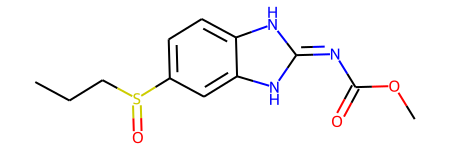

In [1]:
from rdkit import Chem

test = Chem.MolFromSmiles('CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1')

test

In [24]:
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

x = GetMorganFingerprintAsBitVect(test, radius=2, nBits=1024)
y = np.frombuffer(x.ToBitString().encode(), 'u1') - ord('0')

print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

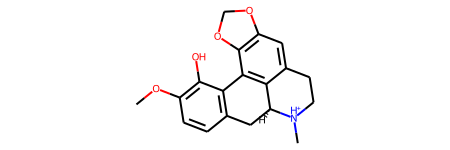

In [25]:
Chem.MolFromSmiles("C[NH+]1CCc2cc3c(c-4c2[C@@H]1Cc5c4c(c(cc5)OC)O)OCO3")

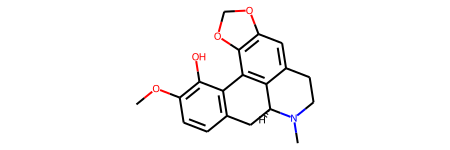

In [26]:
Chem.MolFromSmiles("CN1CCc2cc3c(c-4c2[C@@H]1Cc5c4c(c(cc5)OC)O)OCO3")

# ZINC .smi to .csv

In [30]:
import pandas as pd
import h5py
from rdkit.Chem import MolToSmiles

filename = "../../Data/zynth-templates/zinc_stock.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

inchi = pd.read_hdf(filename, key='table')
inchi = list(np.squeeze(inchi.values))

Keys: <KeysViewHDF5 ['table']>


In [7]:
from rdkit.Chem import SmilesMolSupplier, Draw, MolToSmiles

filename = "../../Data/Zinc/raw/16_p0.smi"
molecules = SmilesMolSupplier(filename)
for i, mol in enumerate(molecules):
    try:
        Draw.MolToFile(mol, f'../../Data/Zinc/preprocessed/samples/{MolToSmiles(mol)}.png')
    except:
        pass
    if i >= 50:
        break

In [12]:
import pandas as pd
import json


with open('../../Data/Uspto/raw/uspto-templates.json') as f:
    d = json.load(f)
    df = pd.DataFrame(d)
    df = df[df['reaction_smarts'].notna()].drop(['reaction_id', 'necessary_reagent'], axis=1)
df

,reactants,intra_only,products,reaction_smarts,dimer_only
0,Cl-[S;H0;D4;+0:1](-[C:2])(=[O;D1;H0:3])=[O;D1;...,False,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...,False
1,Cl-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=...,False,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...,False
2,Cl-[S;H0;D4;+0:1](-[C:2])(=[O;D1;H0:3])=[O;D1;...,False,[C:2]-[S;H0;D4;+0:1](=[O;D1;H0:3])(=[O;D1;H0:4...,[C:2]-[S;H0;D4;+0:1](=[O;D1;H0:3])(=[O;D1;H0:4...,False
3,Cl-[S;H0;D4;+0:1](-[C:2])(=[O;D1;H0:3])=[O;D1;...,False,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...,False
4,Cl-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=...,False,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...,[C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...,False
...,...,...,...,...,...
1808171,Br-[c;H0;D3;+0:1](:[c:2]):[c:3].O-B(-O)-[c;H0;...,False,[#16;a:7]:[c:6]:[c;H0;D3;+0:4](:[c:5])-[c;H0;D...,[#16;a:7]:[c:6]:[c;H0;D3;+0:4](:[c:5])-[c;H0;D...,False
1808172,Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+...,False,[c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...,[c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...,False
1808173,Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+...,False,[c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...,[c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...,False
1808174,Br-[c;H0;D3;+0:1](:[c:2]):[c:3]:[cH;D2;+0:4]:[...,False,[c:2]:[cH;D2;+0:1]:[c:3]:[c;H0;D3;+0:4](:[c:5]...,[c:2]:[cH;D2;+0:1]:[c:3]:[c;H0;D3;+0:4](:[c:5]...,False


In [28]:
import pandas as pd

test = next(pd.read_csv('../../Data/Zinc/processed/zinc7_morgan.csv', chunksize=1000))
with open('../../Data/Zinc/processed/test_zinc7_morgan.csv', 'wb') as f:
    test.to_csv(f, index=False)

In [29]:
test2 = pd.read_csv('../../Data/Zinc/processed/test_zinc7_morgan.csv', chunksize=300)
for x in test2:
    print(x.shape)

(300, 2)
(300, 2)
(300, 2)
(100, 2)


In [15]:
import pandas as pd

with open('../../Data/Zinc/processed/_zinc7_morgan.csv', 'r') as f:
    print(f.readline())
    print(repr(f.readline()))

SMILES,BitString

'CCN(CC)C(=O)COc1ccc(cc1OC)CC=C,00010000000010000000000000000000010000000000000000000000000000000000000000000000100000000000001000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000001000000100000000000000000000010001010000000000000000000000000000000000000000000010000000000000001000000000000000000000000000000010000000000000100000000000000000000000000000000000000000000000000000010000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000010100000000000000000000000000100000000000000000000000000000000000000000001100000000000000000000100000000010001000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000001000000010000000000000000000000000100000100000000000100000000000000000000000000000000000000100000001001001000

In [14]:
df = pd.read_csv('../../Data/Zinc/processed/zinc7_morgan.csv')
df.to_csv('../../Data/Zinc/processed/_zinc7_morgan.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_excel('../../Data/SAC/hartenfeller.xls')
df['smirks'].to_csv('../../Data/SAC/hartenfeller-smirks.csv', index=False)

In [2]:
!pip install xlrd

In [8]:
import re
import pandas as pd

with open('../../Data/SAC/princeton.sdf', 'r') as f:
    store = []
    b = False
    for line in f.readlines():
        if b:
            store.append(line.replace('\n', ''))
        if 'smiles' in line.lower():
            b = True
        else:
            b = False

pd.DataFrame({'SMILES': store}).to_csv('../../Data/SAC/chemdiv_bb.csv', index=False, sep=',')
df = pd.read_csv('../../Data/SAC/chemdiv_bb.csv')
df.to_csv('../../Data/SAC/chemdiv_bb.csv', index=False)